In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Vezilka/SpisokOpstiniMK.csv", encoding="utf-8", skiprows=3)
df.head()

,Матичен број на општина,Назив на општина,Матичен број на населено место,Назив на населено место,Град (г) / Село (с),Unnamed: 5
0,0019,Град Скопје*,499994.0,Скопје,г,NaN
1,0094,Аеродром,419478.0,Долно Лисиче,с,NaN
2,0094,Аеродром,491098.0,Скопје - Аеродром,г,NaN
3,0108,Бутел,419516.0,Визбегово,с,NaN
4,0108,Бутел,414999.0,Љубанци,с,NaN


In [3]:
df = df.iloc[:, :-1]

In [4]:
df.head()

,Матичен број на општина,Назив на општина,Матичен број на населено место,Назив на населено место,Град (г) / Село (с)
0,0019,Град Скопје*,499994.0,Скопје,г
1,0094,Аеродром,419478.0,Долно Лисиче,с
2,0094,Аеродром,491098.0,Скопје - Аеродром,г
3,0108,Бутел,419516.0,Визбегово,с
4,0108,Бутел,414999.0,Љубанци,с


In [5]:
df.columns = [
    "opstina_id",
    "opstina",
    "sifra_nas_mesto",
    "naseleno_mesto",
    "tip_naseleno_mesto"
]

In [6]:
print(df.columns)
print(df.shape)
df.isna().sum()


Index(['opstina_id', 'opstina', 'sifra_nas_mesto', 'naseleno_mesto',
       'tip_naseleno_mesto'],
      dtype='object')
(1779, 5)


,0
opstina_id,1
opstina,2
sifra_nas_mesto,2
naseleno_mesto,2
tip_naseleno_mesto,2


In [7]:
df = df.dropna(subset=["naseleno_mesto", "opstina", "tip_naseleno_mesto"])
df.shape

(1777, 5)

In [8]:
df["tip_naseleno_mesto"] = (
    df["tip_naseleno_mesto"]
    .astype(str)
    .str.strip()
    .replace({"г": "град", "с": "село"})
)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1777 entries, 0 to 1776
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   opstina_id          1777 non-null   object 
 1   opstina             1777 non-null   object 
 2   sifra_nas_mesto     1777 non-null   float64
 3   naseleno_mesto      1777 non-null   object 
 4   tip_naseleno_mesto  1777 non-null   object 
dtypes: float64(1), object(4)
memory usage: 83.3+ KB


In [10]:
!pip -q install "argilla>=2.0.0" pandas tqdm huggingface_hub openai


  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requ

In [ ]:
import argilla as rg
from google.colab import userdata

ARGILLA_API_URL = (userdata.get("ARGILLA_API_URL") or "").strip()
ARGILLA_API_KEY = (userdata.get("ARGILLA_API_KEY") or "").strip()

print("URL repr:", repr(ARGILLA_API_URL))
print("KEY starts with:", ARGILLA_API_KEY[:10])

client = rg.Argilla(api_url=ARGILLA_API_URL, api_key=ARGILLA_API_KEY)
print(client.me)

URL repr: 'https://miloshevskamaja-mk-argilla.hf.space'
KEY starts with: N9L-QfEEmC
User(id=UUID('7d00a144-0cef-4a4c-80b4-6d1823b7fbca') inserted_at=datetime.datetime(2026, 1, 30, 19, 53, 44, 568435) updated_at=datetime.datetime(2026, 1, 30, 19, 53, 44, 568435) username='miloshevskamaja' role=<Role.owner: 'owner'> first_name='miloshevskamaja' last_name=None password=None)


In [11]:
required_cols = ["opstina_id", "opstina",  "sifra_nas_mesto", "naseleno_mesto","tip_naseleno_mesto"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}")

df2 = df.copy()

df2["sifra_nas_mesto"] = df2["sifra_nas_mesto"].astype("Int64").astype(str)

for c in ["naseleno_mesto","opstina"]:
    df2[c] = df2[c].astype(str).str.strip()

df2 = df2.dropna(subset=["naseleno_mesto","opstina","tip_naseleno_mesto"]).reset_index(drop=True)
df2.shape, df2.head(3)

((1777, 5),
   opstina_id       opstina sifra_nas_mesto     naseleno_mesto  \
 0       0019  Град Скопје*          499994             Скопје   
 1       0094      Аеродром          419478       Долно Лисиче   
 2       0094      Аеродром          491098  Скопје - Аеродром   
 
   tip_naseleno_mesto  
 0               град  
 1               село  
 2               град  )

Part 1 - with LLM MistralAi - bad data with hallucination and confusion between Macedonian, Bulgarian and Serbian language  

In [12]:
def make_prompt(row, n_sentences=2):
    return (
        f"Генерирај {n_sentences} кратки, различни реченици на македонски јазик, "
        f"строго базирани на следниве факти (не додавај ништо друго):\n"
        f"- Населено место: {row['naseleno_mesto']}\n"
        f"- Тип: {row['tip_naseleno_mesto']}\n"
        f"- Општина: {row['opstina']}\n"
        "Правила:\n"
        "1) Не измислувај популација, координати, региони, историја.\n"
        "2) Не користи англиски.\n"
        "3) Врати само речениците (секојa во нов ред).\n"
        "4) Ако некој податок недостига, немој да претпоставуваш – користи само даденото.\n"
    )

In [13]:
from google.colab import userdata

In [14]:
from huggingface_hub import InferenceClient

HF_TOKEN = userdata.get("HF_TOKEN")

client_hf = InferenceClient(
    model="mistralai/Mistral-7B-Instruct-v0.2",
    token=HF_TOKEN
)

In [15]:
def gen_hf_chat(prompt, temperature=0.6, max_tokens=220):
    resp = client_hf.chat.completions.create(
        messages=[
            {"role": "system", "content": "Пишувај само на македонски (кирилица). Биди строго фактолошки."},
            {"role": "user", "content": prompt},
        ],
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return resp.choices[0].message.content.strip()


In [16]:
from tqdm import tqdm

N = 200
sample_df = df2.sample(min(N, len(df2)), random_state=42).reset_index(drop=True)

prompts, generations = [], []

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Generating (HF chat)"):
    prompt = make_prompt(row, n_sentences=2)
    prompts.append(prompt)

    try:
        text = gen_hf_chat(prompt)
    except Exception as e:
        text = f"[ERROR] {type(e).__name__}: {e}"

    generations.append(text)

sample_df["prompt"] = prompts
sample_df["generation"] = generations


Generating (HF chat): 100%|██████████| 200/200 [00:17<00:00, 11.46it/s]


In [ ]:
generations

['1. В Орланциот живи и селувјат хора наречени Арачиновци.\n2. Селото Арачиново е част от община Орланци.',
 '1. Село Липково е част од општина Стрима.\n2. Липково - село в Стримска регија, Северна Македонија.',
 '1. Село Крива Паланка е част от община Нерав.\n2. Крива Паланка е селце в Община Нерав.',
 '1. Село Чашка се налази во општина Раковец.\n2. Раковец е општина где живут хора во село Чашка.',
 '1. Село Кратово е част от општина Татомир.\n2. Кратово - село в границите на община Татомир.',
 '1. Село Струга е част от община Дренок.\n2. Дренокската община е дома на село Струга.',
 '1. Македонски Брод е град, седетел на Община Македонски Брод.\n2. Градският център Македонски Брод е част от Община със същото име.',
 '1. Село в општина Горно Оризари, Македонија - това е Велес.\n2. Велешко село се налази во Горно Оризари.',
 '1. Село Петровец е част от община Дивље.\n2. Петровец е село в община Дивље.',
 '1. Село Старо Нагоричане се налази в општина Арбанашко.\n2. У централната част на

Part 2 - Template Based Generation

In [17]:
import random

TEMPLATES = [
    lambda r: [
        f"„{r['naseleno_mesto']}“ е {r['tip_naseleno_mesto']} во општина „{r['opstina']}“.",
        f"Населеното место „{r['naseleno_mesto']}“ припаѓа на општина „{r['opstina']}“."
    ],
    lambda r: [
        f"{r['tip_naseleno_mesto'].capitalize()}то „{r['naseleno_mesto']}“ се наоѓа во општина „{r['opstina']}“.",
        f"Општина „{r['opstina']}“ го опфаќа населеното место „{r['naseleno_mesto']}“."
    ],
    lambda r: [
        f"„{r['naseleno_mesto']}“ е населено место од тип {r['tip_naseleno_mesto']} во општина „{r['opstina']}“.",
        f"Како {r['tip_naseleno_mesto']}, „{r['naseleno_mesto']}“ административно припаѓа на општина „{r['opstina']}“."
    ],
    lambda r: [
        f"Во општина „{r['opstina']}“ се наоѓа {r['tip_naseleno_mesto']}то „{r['naseleno_mesto']}“.",
        f"„{r['naseleno_mesto']}“ е {r['tip_naseleno_mesto']} кое е дел од општина „{r['opstina']}“."
    ],
]




In [18]:
def gen_template_var(row, seed=None):
    if seed is not None:
        random.seed(seed)
    tmpl = random.choice(TEMPLATES)
    lines = tmpl(row)
    return "\n".join(lines)

In [19]:
from tqdm import tqdm
import pandas as pd

N = len(df2)
sample_df = df2.sample(N, random_state=42).reset_index(drop=True)

generations = []

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Template-based generation"):
    text = gen_template_var(row)
    generations.append(text)

sample_df["generation"] = generations

sample_df[["naseleno_mesto", "opstina", "tip_naseleno_mesto", "generation"]].head(10)


Template-based generation: 100%|██████████| 1777/1777 [00:00<00:00, 20323.17it/s]


,naseleno_mesto,opstina,tip_naseleno_mesto,generation
0,Орланци,Арачиново,село,„Орланци“ е село во општина „Арачиново“.\nНасе...
1,Стрима,Липково,село,Селото „Стрима“ се наоѓа во општина „Липково“....
2,Нерав,Крива Паланка,село,Во општина „Крива Паланка“ се наоѓа селото „Не...
3,Раковец,Чашка,село,„Раковец“ е населено место од тип село во општ...
4,Татомир,Кратово,село,„Татомир“ е село во општина „Кратово“.\nНаселе...
5,Дренок,Струга,село,„Дренок“ е село во општина „Струга“.\nНаселено...
6,Македонски Брод,Македонски Брод,град,Градто „Македонски Брод“ се наоѓа во општина „...
7,Горно Оризари,Велес,село,„Горно Оризари“ е населено место од тип село в...
8,Дивље,Петровец,село,Во општина „Петровец“ се наоѓа селото „Дивље“....
9,Арбанашко,Старо Нагоричане,село,Во општина „Старо Нагоричане“ се наоѓа селото ...


In [ ]:
generations


['„Орланци“ е село во општина „Арачиново“.\nНаселеното место „Орланци“ припаѓа на општина „Арачиново“.',
 '„Стрима“ е село во општина „Липково“.\nНаселеното место „Стрима“ припаѓа на општина „Липково“.',
 '„Нерав“ е населено место од тип село во општина „Крива Паланка“.\nКако село, „Нерав“ административно припаѓа на општина „Крива Паланка“.',
 'Во општина „Чашка“ се наоѓа селото „Раковец“.\n„Раковец“ е село кое е дел од општина „Чашка“.',
 '„Татомир“ е населено место од тип село во општина „Кратово“.\nКако село, „Татомир“ административно припаѓа на општина „Кратово“.',
 '„Дренок“ е село во општина „Струга“.\nНаселеното место „Дренок“ припаѓа на општина „Струга“.',
 'Градто „Македонски Брод“ се наоѓа во општина „Македонски Брод“.\nОпштина „Македонски Брод“ го опфаќа населеното место „Македонски Брод“.',
 'Селото „Горно Оризари“ се наоѓа во општина „Велес“.\nОпштина „Велес“ го опфаќа населеното место „Горно Оризари“.',
 '„Дивље“ е село во општина „Петровец“.\nНаселеното место „Дивље“ при

In [20]:
import json

def make_sft_prompt(row):
    return (
        f"Населено место: {row['naseleno_mesto']}\n"
        f"Тип: {row['tip_naseleno_mesto']}\n"
        f"Општина: {row['opstina']}\n"
        f"Напиши две фактолошки реченици на македонски."
    )

records = []
for _, row in sample_df.iterrows():
    records.append({
        "prompt": make_sft_prompt(row),
        "completion": row["generation"]
    })

with open("mk_settlements_template_sft.jsonl", "w", encoding="utf-8") as f:
    for r in records:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Saved: mk_settlements_template_sft.jsonl")


Saved: mk_settlements_template_sft.jsonl


Part 3 - Generate synthetic data using KGs

In [ ]:
import pandas as pd

In [21]:
def build_triples(df):
    triples = []
    for _, r in df.iterrows():
        nm = r["naseleno_mesto"]
        op = r["opstina"]
        typ = r["tip_naseleno_mesto"]

        triples.append((nm, "е_тип", typ))
        triples.append((nm, "припаѓа_на", op))
        triples.append((op, "има_населено_место", nm))
    return pd.DataFrame(triples, columns=["subj", "pred", "obj"])

In [23]:
triples_df = build_triples(df2)
triples_df.head(10), triples_df.shape

(                subj                pred                obj
 0             Скопје               е_тип               град
 1             Скопје          припаѓа_на       Град Скопје*
 2       Град Скопје*  има_населено_место             Скопје
 3       Долно Лисиче               е_тип               село
 4       Долно Лисиче          припаѓа_на           Аеродром
 5           Аеродром  има_населено_место       Долно Лисиче
 6  Скопје - Аеродром               е_тип               град
 7  Скопје - Аеродром          припаѓа_на           Аеродром
 8           Аеродром  има_населено_место  Скопје - Аеродром
 9          Визбегово               е_тип               село,
 (5331, 3))

In [22]:
from collections import defaultdict

In [24]:
# општина -> листа на населени места
op_to_nm = defaultdict(list)

# населено место -> општина
nm_to_op = {}

# населено место -> тип
nm_to_type = {}

In [25]:
for _, r in df2.iterrows():
    nm = r["naseleno_mesto"]
    op = r["opstina"]
    typ = r["tip_naseleno_mesto"]
    op_to_nm[op].append(nm)
    nm_to_op[nm] = op
    nm_to_type[nm] = typ

In [26]:
import random

def kg_text_for_row(row, seed=None):
    if seed is not None:
        random.seed(seed)

    nm = row["naseleno_mesto"]
    op = row["opstina"]
    typ = row["tip_naseleno_mesto"]

    neighbors = [x for x in op_to_nm[op] if x != nm]
    other = random.choice(neighbors) if neighbors else None
    other_typ = nm_to_type.get(other) if other else None

    candidates = []

    candidates.append(
        "\n".join([
            f"„{nm}“ е {typ} во општина „{op}“.",
            f"Општина „{op}“ го опфаќа населеното место „{nm}“."
        ])
    )

    candidates.append(
        "\n".join([
            f"Во општина „{op}“ се наоѓа {typ}то „{nm}“.",
            f"Населеното место „{nm}“ административно припаѓа на општина „{op}“."
        ])
    )

    if other:
        candidates.append(
            "\n".join([
                f"„{nm}“ е {typ} во општина „{op}“.",
                f"Во истата општина се наоѓа и {other_typ}то „{other}“."
            ])
        )
        candidates.append(
            "\n".join([
                f"Општина „{op}“ ги опфаќа населените места „{nm}“ и „{other}“.",
                f"„{nm}“ е {typ}, а „{other}“ е {other_typ}."
            ])
        )

    if other:
        candidates.append(
            "\n".join([
                f"Во општина „{op}“ се наоѓаат „{nm}“ и „{other}“.",
                f"„{nm}“ е {typ}, додека „{other}“ е {other_typ}."
            ])
        )

    return random.choice(candidates)


In [27]:
from tqdm import tqdm

kg_generations = []
for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="KG-based generation"):
    kg_generations.append(kg_text_for_row(row))

sample_df["kg_generation"] = kg_generations

sample_df[["naseleno_mesto","opstina","tip_naseleno_mesto","generation","kg_generation"]].head(10)


KG-based generation: 100%|██████████| 1777/1777 [00:00<00:00, 19834.63it/s]


,naseleno_mesto,opstina,tip_naseleno_mesto,generation,kg_generation
0,Орланци,Арачиново,село,„Орланци“ е село во општина „Арачиново“.\nНасе...,„Орланци“ е село во општина „Арачиново“.\nВо и...
1,Стрима,Липково,село,Селото „Стрима“ се наоѓа во општина „Липково“....,„Стрима“ е село во општина „Липково“.\nВо иста...
2,Нерав,Крива Паланка,село,Во општина „Крива Паланка“ се наоѓа селото „Не...,Општина „Крива Паланка“ ги опфаќа населените м...
3,Раковец,Чашка,село,„Раковец“ е населено место од тип село во општ...,Општина „Чашка“ ги опфаќа населените места „Ра...
4,Татомир,Кратово,село,„Татомир“ е село во општина „Кратово“.\nНаселе...,Општина „Кратово“ ги опфаќа населените места „...
5,Дренок,Струга,село,„Дренок“ е село во општина „Струга“.\nНаселено...,„Дренок“ е село во општина „Струга“.\nОпштина ...
6,Македонски Брод,Македонски Брод,град,Градто „Македонски Брод“ се наоѓа во општина „...,„Македонски Брод“ е град во општина „Македонск...
7,Горно Оризари,Велес,село,„Горно Оризари“ е населено место од тип село в...,Во општина „Велес“ се наоѓа селото „Горно Ориз...
8,Дивље,Петровец,село,Во општина „Петровец“ се наоѓа селото „Дивље“....,Во општина „Петровец“ се наоѓаат „Дивље“ и „Ле...
9,Арбанашко,Старо Нагоричане,село,Во општина „Старо Нагоричане“ се наоѓа селото ...,„Арбанашко“ е село во општина „Старо Нагоричан...


In [ ]:
kg_generations

['„Орланци“ е село во општина „Арачиново“.\nВо истата општина се наоѓа и селото „Арачиново“.',
 'Во општина „Липково“ се наоѓа селото „Стрима“.\nНаселеното место „Стрима“ административно припаѓа на општина „Липково“.',
 'Во општина „Крива Паланка“ се наоѓаат „Нерав“ и „Станци“.\n„Нерав“ е село, додека „Станци“ е село.',
 'Општина „Чашка“ ги опфаќа населените места „Раковец“ и „Извор“.\n„Раковец“ е село, а „Извор“ е село.',
 '„Татомир“ е село во општина „Кратово“.\nВо истата општина се наоѓа и градто „Кратово“.',
 'Во општина „Струга“ се наоѓа селото „Дренок“.\nНаселеното место „Дренок“ административно припаѓа на општина „Струга“.',
 '„Македонски Брод“ е град во општина „Македонски Брод“.\nВо истата општина се наоѓа и селото „Долно Ботушје“.',
 '„Горно Оризари“ е село во општина „Велес“.\nВо истата општина се наоѓа и селото „Башино Село“.',
 'Во општина „Петровец“ се наоѓа селото „Дивље“.\nНаселеното место „Дивље“ административно припаѓа на општина „Петровец“.',
 'Во општина „Старо Наго

In [28]:
rows = []
for _, r in sample_df.iterrows():
    base = {
        "opstina_id": r["opstina_id"],
        "sifra_nas_mesto": r["sifra_nas_mesto"],
        "naseleno_mesto": r["naseleno_mesto"],
        "opstina": r["opstina"],
        "tip_naseleno_mesto": r["tip_naseleno_mesto"],
    }
    rows.append({**base, "source": "template", "text": r["generation"]})
    rows.append({**base, "source": "kg", "text": r["kg_generation"]})

train_df = pd.DataFrame(rows)


In [29]:
train_df.shape

(3554, 7)

In [ ]:
train_df.head(5)

,opstina_id,sifra_nas_mesto,naseleno_mesto,opstina,tip_naseleno_mesto,source,text
0,1015,414026,Орланци,Арачиново,село,template,Селото „Орланци“ се наоѓа во општина „Арачинов...
1,1015,414026,Орланци,Арачиново,село,kg,„Орланци“ е село во општина „Арачиново“.\nВо и...
2,1694,409430,Стрима,Липково,село,template,„Стрима“ е населено место од тип село во општи...
3,1694,409430,Стрима,Липково,село,kg,Во општина „Липково“ се наоѓа селото „Стрима“....
4,1627,407925,Нерав,Крива Паланка,село,template,Во општина „Крива Паланка“ се наоѓа селото „Не...


In [31]:
train_df['text'][15]

'Општина „Велес“ ги опфаќа населените места „Горно Оризари“ и „Белештевица“.\n„Горно Оризари“ е село, а „Белештевица“ е село.'

In [30]:
import json

def make_prompt_from_row(r):
    return (
        f"Населено место: {r['naseleno_mesto']}\n"
        f"Тип: {r['tip_naseleno_mesto']}\n"
        f"Општина: {r['opstina']}\n"
        f"Напиши две фактолошки реченици на македонски."
    )

out_path = "synthetic_sententes_kg.jsonl"
with open(out_path, "w", encoding="utf-8") as f:
    for _, r in train_df.iterrows():
        rec = {
            "prompt": make_prompt_from_row(r),
            "completion": r["text"],
            "meta": {"source": r["source"]}
        }
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")

print("Saved:", out_path)


Saved: synthetic_sententes_kg.jsonl


Part 4 - KGAST pipeline

In [31]:
!pip -q install sentence-transformers faiss-cpu rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 111.2 MB/s eta 0:00:00


In [32]:
import json, random, re, math
import numpy as np
import pandas as pd
from tqdm import tqdm
from rapidfuzz import fuzz, process
from sentence_transformers import SentenceTransformer
import faiss

In [33]:
CONFIG = {
    "kshots": 4,
    "num_candidates": 3,
    "vote_runs": 5,
    "annot_runs": 5,
    "annot_threshold": 0.5,

    "min_triple_coverage": 1.0,
    "max_unknown_entity_ratio": 0.20,
    "entity_match_threshold": 90,
    "triple_match_threshold": 88,

    "max_regen_rounds": 3,
    "gen_temperature": 0.8,
    "gen_max_new_tokens": 220,

    "vote_temperature": 0.3,
    "vote_max_new_tokens": 5,

    "json_temperature": 0.2,
    "json_max_new_tokens": 420,
}

RELATIONS = ["е_тип", "припаѓа_на", "има_населено_место"]

In [34]:
def normalize_text(s: str) -> str:
    s = (s or "").strip()
    s = re.sub(r"\s+", " ", s)
    return s

def norm_key(s: str) -> str:
    s = normalize_text(s).lower()
    s = re.sub(r"[\"'“”‘’\(\)\[\]\{\}\,\.\:\;\!\?\-–—/\\]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize_simple(s: str):
    s = norm_key(s)
    return [t for t in s.split(" ") if t]

In [35]:
def fuzzy_in_text(entity: str, text: str, threshold: int = 90) -> bool:
    """
    Robust presence check: fuzzy partial ratio over normalized forms.
    """
    e = norm_key(entity)
    t = norm_key(text)
    if not e or not t:
        return False

    if e in t:
        return True

    return fuzz.partial_ratio(e, t) >= threshold

def best_fuzzy_match(query: str, choices: list[str], threshold: int = 90):
    if not choices:
        return None, 0
    match = process.extractOne(query, choices, scorer=fuzz.WRatio)
    if not match:
        return None, 0
    cand, score, _ = match
    if score >= threshold:
        return cand, score
    return None, score

In [36]:
#Building richer kg triples per row
"""
KG triples from structured table. Keep it factual.
Adds optional neighbor facts within same municipality for mild diversity.
"""


def build_row_kg(row, seed=None):
    if seed is not None:
        random.seed(seed)

    nm  = normalize_text(row["naseleno_mesto"])
    op  = normalize_text(row["opstina"])
    typ = normalize_text(row["tip_naseleno_mesto"])

    nm_type  = "LOC"
    op_type  = "LOC"
    typ_type = "MISC"

    triples = [
        (nm, "е_тип", typ, nm_type, typ_type),
        (nm, "припаѓа_на", op, nm_type, op_type),
        (op, "има_населено_место", nm, op_type, nm_type),
    ]

    neighbors = [x for x in op_to_nm.get(op, []) if normalize_text(x) != nm]
    if neighbors:
        other = normalize_text(random.choice(neighbors))
        other_typ = normalize_text(nm_to_type.get(other, ""))
        triples += [
            (op, "има_населено_место", other, op_type, nm_type),
            (other, "припаѓа_на", op, nm_type, op_type),
        ]
        if other_typ:
            triples.append((other, "е_тип", other_typ, nm_type, "MISC"))

    return triples

In [37]:
#Natural-language triple format (KGAST-style representation).

def kg_to_nl_triples(triples):
    out = []
    for h, r, t, ht, tt in triples:
        out.append(f'("{h}":{ht}, "{r}", "{t}":{tt})')
    return "\n".join(out)

In [38]:
# Better for embedding retrieval than raw symbol-heavy triples.
def kg_signature(triples):
    ents = []
    rels = []
    for h, r, t, ht, tt in triples:
        ents.append(f"{h}({ht})")
        ents.append(f"{t}({tt})")
        rels.append(r)
    ents = list(dict.fromkeys(ents))
    rels = list(dict.fromkeys(rels))
    return " | ".join([
        "ENTITIES: " + ", ".join(ents),
        "RELATIONS: " + ", ".join(rels),
    ])

In [39]:
def get_kg_entities(triples):
    ents = []
    for h, r, t, ht, tt in triples:
        ents.append(h)
        ents.append(t)
    return list(dict.fromkeys([normalize_text(x) for x in ents if normalize_text(x)]))


In [40]:
def make_example_bank(df_like):
    bank = []
    for _, r in df_like.iterrows():
        triples = build_row_kg(r, seed=42)
        bank.append({
            "text": normalize_text(r["text"]),
            "kg_triples": triples,
            "kg_str": kg_to_nl_triples(triples),
            "sig": kg_signature(triples),
        })
    return bank

In [41]:
example_bank = make_example_bank(train_df)

In [42]:
def fallback_example_bank_from_table(df_like, n=500, seed=42):
    rnd = df_like.sample(n=min(n, len(df_like)), random_state=seed).reset_index(drop=True)
    bank = []
    for _, r in rnd.iterrows():
        triples = build_row_kg(r, seed=seed)
        nm  = normalize_text(r["naseleno_mesto"])
        op  = normalize_text(r["opstina"])
        typ = normalize_text(r["tip_naseleno_mesto"])
        text = f"{nm} е {typ} и припаѓа на општина {op}."
        bank.append({
            "text": text,
            "kg_triples": triples,
            "kg_str": kg_to_nl_triples(triples),
            "sig": kg_signature(triples),
        })
    return bank

In [43]:
try:
    example_bank
except NameError:
    example_bank = fallback_example_bank_from_table(sample_df, n=700)

In [44]:
embedder = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

sig_texts = [e["sig"] for e in example_bank]
emb = embedder.encode(sig_texts, normalize_embeddings=True, show_progress_bar=True).astype("float32")

index = faiss.IndexFlatIP(emb.shape[1])
index.add(emb)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/526 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

In [45]:
def retrieve_kshots(query_triples, k=4):
    qsig = kg_signature(query_triples)
    q = embedder.encode([qsig], normalize_embeddings=True).astype("float32")
    scores, ids = index.search(q, k)
    return [example_bank[i] for i in ids[0]]

In [46]:
def format_kshot_block(kshots):
    blocks = []
    for ex in kshots:
        blocks.append(
            "### Пример\n"
            "KG:\n" + ex["kg_str"] + "\n"
            "Текст:\n" + ex["text"]
        )
    return "\n\n".join(blocks)

In [47]:
from openai import OpenAI
import re, json

client = OpenAI(api_key=userdata.get("OPENAI_API_KEY"))
MODEL_ID = "gpt-4o-mini"

In [48]:
def call_llm(prompt, max_new_tokens=220, temperature=0.7, top_p=0.9):
    resp = client.chat.completions.create(
        model=MODEL_ID,
        messages=[{"role":"user","content":prompt}],
        max_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p
    )
    return resp.choices[0].message.content.strip()

In [49]:
def call_llm_json(prompt, max_new_tokens=420, temperature=0.2, top_p=0.9):
    prompt = prompt + "\n\nReturn ONLY valid JSON. No extra text."
    txt = call_llm(prompt, max_new_tokens=max_new_tokens, temperature=temperature, top_p=top_p)
    m = re.search(r"\{.*\}", txt, flags=re.S)
    if not m:
        raise ValueError("No JSON found:\n" + txt[:400])
    return json.loads(m.group(0))

In [50]:
#test if the model works
print(call_llm("Кажи една реченица на македонски за Скопје.", max_new_tokens=60))


Скопје е главниот град на Северна Македонија и е познат по својата богата историја и културно наследство.


In [51]:
def style_directive(seed=None):
    variants = [
        "Енциклопедиски стил, кратко и јасно.",
        "Наративно, но формално; избегнувај претерување.",
        "Неутрален информативен опис, природен македонски.",
        "Краток опис со 2–3 реченици.",
        "Опис со 3–4 реченици, но без нови факти."
    ]
    if seed is not None:
        random.seed(seed)
    return random.choice(variants)

In [52]:
GEN_INSTRUCTION = (
    "Ти си автор кој пишува СТРОГО фактолошки текст на македонски.\n"
    "Ќе добиеш Knowledge Graph тројки. Твојот текст мора да ги содржи СИТЕ факти од тројките.\n"
    "Правила:\n"
    "- НЕ додавај нови факти/ентитети кои не се во тројките.\n"
    "- НЕ менувај релации (ако е 'припаѓа_на' мора да остане тоа значење).\n"
    "- Пиши природен македонски; без листи и без markdown.\n"
)

In [53]:
def build_generation_prompt(query_kg_str, kshots, seed=None):
    return (
        GEN_INSTRUCTION + "\n"
        + "Стил: " + style_directive(seed) + "\n\n"
        + format_kshot_block(kshots)
        + "\n\n### Влез (KG)\n" + query_kg_str
        + "\n\n### Излез\nТекст:"
    )

In [54]:
VOTE_INSTRUCTION = (
    "Избери го најдобриот кандидат според:\n"
    "1) Покриеност на сите тројки,\n"
    "2) Нема нови факти/ентитети,\n"
    "3) Кохерентен природен македонски.\n"
    "Одговори само со: A или B или C."
)

In [55]:
def build_vote_prompt(query_kg_str, cands):
    return (
        VOTE_INSTRUCTION
        + "\n\nKG:\n" + query_kg_str
        + "\n\nA:\n" + cands[0]
        + "\n\nB:\n" + cands[1]
        + "\n\nC:\n" + cands[2]
        + "\n\nОдговор:"
    )


In [56]:
ANNOT_INSTRUCTION = (
    "Ти си анототатор.\n"
    "Извлечи ентитети и релации од текстот.\n"
    "Ентитети: тип PER, LOC, ORG, TIME, NUM, MISC.\n"
    "Релации: користи само: е_тип, припаѓа_на, има_населено_место.\n"
    "Врати СТРОГО JSON со клучеви: entities, relations.\n"
    "entities: листа {text, type}\n"
    "relations: листа {head, relation, tail}\n"
)

In [57]:
def build_annot_prompt(text):
    return ANNOT_INSTRUCTION + "\n\nТекст:\n" + text + "\n\nJSON:"

In [58]:
#Coverage: fraction of triples whose head and tail are mentioned (fuzzy).

def triple_coverage(text: str, triples, threshold=88):
    t = normalize_text(text)
    ok = 0
    for h, r, o, ht, ot in triples:
        h_ok = fuzzy_in_text(h, t, threshold)
        o_ok = fuzzy_in_text(o, t, threshold)
        if h_ok and o_ok:
            ok += 1
    return ok / max(len(triples), 1)

In [59]:
def extract_candidate_entities(text: str):
    s = normalize_text(text)

    pattern = r"(?:[А-ШЃЌЉЊЏ][а-шѓќљњџ]+(?:\s+[А-ШЃЌЉЊЏ][а-шѓќљњџ]+)*)"
    ents = re.findall(pattern, s)

    ents = [e.strip() for e in ents if len(e.strip()) >= 3]
    uniq = []
    seen = set()
    for e in ents:
        k = norm_key(e)
        if k and k not in seen:
            uniq.append(e)
            seen.add(k)
    return uniq

In [80]:
def extract_quoted_entities(text: str) -> list[str]:
    return [s.strip() for s in re.findall(r"„([^“]+)“", text or "") if s.strip()]

In [81]:
def unknown_entity_ratio(text: str, kg_entities: list[str], match_threshold=90):
    cand_ents = extract_quoted_entities(text)
    if not cand_ents:
        return 0.0, []

    unknown = []
    for ce in cand_ents:
        m, score = best_fuzzy_match(ce, kg_entities, threshold=match_threshold)
        if m is None:
            unknown.append(ce)

    ratio = len(unknown) / max(len(cand_ents), 1)
    return ratio, unknown

In [61]:
def validate_candidate(text: str, triples, config=CONFIG):
    """
    Strict validation:
    - must cover all triples (or >= min_triple_coverage)
    - must not introduce too many unknown entities
    """
    if not text or len(text) < 15:
        return False, {"reason": "too_short"}

    cov = triple_coverage(text, triples, threshold=config["triple_match_threshold"])
    if cov < config["min_triple_coverage"]:
        return False, {"reason": "low_coverage", "coverage": cov}

    kg_ents = get_kg_entities(triples)
    unk_ratio, unk = unknown_entity_ratio(text, kg_ents, match_threshold=config["entity_match_threshold"])
    if unk_ratio > config["max_unknown_entity_ratio"]:
        return False, {"reason": "too_many_unknown_entities", "unknown_ratio": unk_ratio, "unknown": unk[:10]}

    return True, {"coverage": cov, "unknown_ratio": unk_ratio}

In [62]:
def generate_candidates(query_triples, kshots, seed=None, config=CONFIG):
    query_kg_str = kg_to_nl_triples(query_triples)
    prompt = build_generation_prompt(query_kg_str, kshots, seed=seed)
    cands = []
    for i in range(config["num_candidates"]):
        c = call_llm(
            prompt,
            max_new_tokens=config["gen_max_new_tokens"],
            temperature=config["gen_temperature"],
            top_p=0.9
        )
        cands.append(c)
    return cands


In [63]:
def deterministic_rank(text, triples, config=CONFIG):

    cov = triple_coverage(text, triples, threshold=config["triple_match_threshold"])
    unk_ratio, unk = unknown_entity_ratio(text, get_kg_entities(triples), match_threshold=config["entity_match_threshold"])
    length_penalty = 0.0
    if len(text) < 40: length_penalty += 0.05
    if len(text) > 420: length_penalty += 0.05
    score = cov - 0.7 * unk_ratio - length_penalty
    return score, {"coverage": cov, "unknown_ratio": unk_ratio, "unknown": unk[:8]}

In [64]:
def vote_best(query_triples, cands, config=CONFIG):
    """
    KGAST voting with deterministic tie-break.
    """
    query_kg_str = kg_to_nl_triples(query_triples)

    votes = {"A":0, "B":0, "C":0}
    vote_prompt = build_vote_prompt(query_kg_str, cands)
    for _ in range(config["vote_runs"]):
        v = call_llm(
            vote_prompt,
            max_new_tokens=config["vote_max_new_tokens"],
            temperature=config["vote_temperature"],
            top_p=1.0
        ).strip().upper()[:1]
        if v in votes:
            votes[v] += 1

    # pick by votes; if tie, deterministic ranking
    best_letter = max(votes, key=votes.get)
    best_idx = {"A":0, "B":1, "C":2}[best_letter]

    # tie-break
    sorted_votes = sorted(votes.items(), key=lambda x: x[1], reverse=True)
    if len(sorted_votes) >= 2 and sorted_votes[0][1] == sorted_votes[1][1]:
        ranks = []
        for i, c in enumerate(cands):
            s, meta = deterministic_rank(c, query_triples, config)
            ranks.append((s, i, meta))
        ranks.sort(reverse=True, key=lambda x: x[0])
        best_idx = ranks[0][1]
        best_letter = ["A","B","C"][best_idx]

    return cands[best_idx], votes, best_letter

In [65]:
def naive_filter_triples(triples, text, threshold=88):
    kept = []
    for h, r, o, ht, ot in triples:
        if fuzzy_in_text(h, text, threshold) and fuzzy_in_text(o, text, threshold):
            kept.append((h, r, o, ht, ot))
    return kept


In [66]:
def canonical_entity_key(ent_text, ent_type):
    return (norm_key(ent_text), ent_type)

def canonical_rel_key(h, r, o):
    return (norm_key(h), r, norm_key(o))

In [67]:
def majority_merge_annotations(ann_list, threshold=0.5):
    n = len(ann_list)
    ent_counts = {}
    rel_counts = {}

    for ann in ann_list:
        for e in ann.get("entities", []):
            key = canonical_entity_key(e.get("text",""), e.get("type","MISC"))
            if key[0]:
                ent_counts[key] = ent_counts.get(key, 0) + 1
        for rel in ann.get("relations", []):
            key = canonical_rel_key(rel.get("head",""), rel.get("relation",""), rel.get("tail",""))
            if key[0] and key[2] and key[1]:
                rel_counts[key] = rel_counts.get(key, 0) + 1

    ents = [{"text": k[0], "type": k[1]} for k,c in ent_counts.items() if c >= threshold*n]
    rels = [{"head": k[0], "relation": k[1], "tail": k[2]} for k,c in rel_counts.items() if c >= threshold*n]
    return {"entities": ents, "relations": rels}

In [68]:
def annotate_with_self_consistency(text, config=CONFIG):
    anns = []
    for _ in range(config["annot_runs"]):
        try:
            anns.append(call_llm_json(
                build_annot_prompt(text),
                max_new_tokens=config["json_max_new_tokens"],
                temperature=config["json_temperature"],
                top_p=0.9
            ))
        except Exception:
            continue
    if not anns:
        return {"entities": [], "relations": []}
    return majority_merge_annotations(anns, threshold=config["annot_threshold"])

In [69]:
"""
Snap extracted entities to the closest KG entity mention to reduce noise.
"""
def snap_entities_to_kg(entities, kg_entities, threshold=90):

    snapped = []
    for e in entities:
        txt = e.get("text","")
        typ = e.get("type","MISC")
        m, score = best_fuzzy_match(txt, kg_entities, threshold=threshold)
        if m is not None:
            snapped.append({"text": m, "type": typ})
    uniq = []
    seen = set()
    for e in snapped:
        k = (norm_key(e["text"]), e["type"])
        if k not in seen:
            uniq.append(e); seen.add(k)
    return uniq

In [82]:
def build_kg_entity_index(triples):
    idx = {}
    for h, r, o, ht, ot in triples:
        idx[str(h)] = ht or "LOC"
        idx[str(o)] = ot or "LOC"
    return idx

def entities_from_text_kg(triples, text: str, match_threshold=90):
    kg_idx = build_kg_entity_index(triples)
    kg_entities = list(kg_idx.keys())

    ents = []
    seen = set()
    for m in extract_quoted_entities(text):
        best, score = best_fuzzy_match(m, kg_entities, threshold=match_threshold)
        if best is None:
            continue
        if best in seen:
            continue
        seen.add(best)
        ents.append({
            "text": m,
            "kg_id": best,
            "type": kg_idx.get(best, "LOC"),
            "match_score": score
        })
    return ents


In [83]:
def kgast_synthesize_row(row, seed=None, config=CONFIG):
    triples = build_row_kg(row, seed=seed)
    kshots = retrieve_kshots(triples, k=config["kshots"])

    debug = {"regen_rounds": 0, "attempts": []}

    for round_i in range(config["max_regen_rounds"]):
        debug["regen_rounds"] = round_i + 1

        cands = generate_candidates(triples, kshots, seed=(None if seed is None else seed+round_i), config=config)

        # Coverage-first filter: keep only candidates that pass strict validation
        valids = []
        for c in cands:
            ok, meta = validate_candidate(c, triples, config)
            score, rank_meta = deterministic_rank(c, triples, config)
            debug["attempts"].append({"text": c, "valid": ok, "meta": {**meta, **rank_meta, "score": score}})
            if ok:
                valids.append(c)

        # If none valid, regen (next loop)
        if not valids:
            continue

        # If 1 valid, take it; else vote among first 3 (pad if fewer)
        if len(valids) == 1:
            best_text = valids[0]
            vote_stats = {"A":0,"B":0,"C":0}
            vote_pick = "A"
        else:
            # Ensure exactly 3 candidates for voting
            pool = valids[:3]
            while len(pool) < 3:
                pool.append(valids[-1])
            best_text, vote_stats, vote_pick = vote_best(triples, pool, config)

        # Final validation (must pass)
        ok, meta = validate_candidate(best_text, triples, config)
        if not ok:
            continue

        # Filter KG triples grounded in output text (robust fuzzy)
        filtered = naive_filter_triples(triples, best_text, threshold=config["triple_match_threshold"])

        kg_ents = get_kg_entities(triples)

        ann_entities = entities_from_text_kg(triples, best_text, match_threshold=config["entity_match_threshold"])


        filtered_relations = [{"head":h, "relation":r, "tail":o} for (h,r,o,_,_) in filtered]

        record = {
            "text": best_text,
            "kg_input": [{"head":h, "relation":r, "tail":o, "head_type":ht, "tail_type":ot} for (h,r,o,ht,ot) in triples],
            "kg_filtered": filtered_relations,
            "annotations": {
                "entities": ann_entities,
                "relations": filtered_relations
            },
            "meta": {
                "vote_stats": vote_stats,
                "vote_pick": vote_pick,
                "coverage": triple_coverage(best_text, triples, threshold=config["triple_match_threshold"]),
                "unknown_entity_ratio": unknown_entity_ratio(best_text, kg_ents, match_threshold=config["entity_match_threshold"])[0],
                "debug": debug if round_i == config["max_regen_rounds"]-1 else debug
            }
        }
        return record

    return {
        "text": "",
        "kg_input": [{"head":h, "relation":r, "tail":o, "head_type":ht, "tail_type":ot} for (h,r,o,ht,ot) in triples],
        "kg_filtered": [],
        "annotations": {"entities": [], "relations": []},
        "meta": {"failed": True, "debug": debug}
    }


In [84]:
N = min(200, len(sample_df))
rows_for_gen = sample_df.sample(n=N, random_state=42).reset_index(drop=True)

synthetic_records = []
for i, row in tqdm(rows_for_gen.iterrows(), total=len(rows_for_gen), desc="KGAST synth"):
    rec = kgast_synthesize_row(row, seed=1000+i, config=CONFIG)
    if rec.get("meta", {}).get("failed"):
        continue
    synthetic_records.append(rec)


KGAST synth: 100%|██████████| 200/200 [17:29<00:00,  5.25s/it]


In [85]:
def sft_prompt_from_kg(rec):
    kg_lines = []
    for t in rec["kg_input"]:
        kg_lines.append(f'("{t["head"]}", "{t["relation"]}", "{t["tail"]}")')
    kg_block = "\n".join(kg_lines)
    return (
        "Напиши 2–4 кохерентни реченици на македонски кои ги вклучуваат сите факти од тројките.\n"
        "Не додавај нови факти или ентитети.\n\n"
        "Тројки:\n" + kg_block + "\n\nТекст:"
    )

In [86]:
out_ie = "mk_kgast_ie.jsonl"
with open(out_ie, "w", encoding="utf-8") as f:
    for r in synthetic_records:
        if r.get("text"):
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

In [87]:
out_sft = "mk_kgast_sft.jsonl"
with open(out_sft, "w", encoding="utf-8") as f:
    for r in synthetic_records:
        if r.get("text"):
            f.write(json.dumps({
                "prompt": sft_prompt_from_kg(r),
                "completion": r["text"],
                "meta": r["meta"]
            }, ensure_ascii=False) + "\n")

In [75]:
out_ie, out_sft

('mk_kgast_ie.jsonl', 'mk_kgast_sft.jsonl')

In [88]:
import json
with open("mk_kgast_sft.jsonl", "r", encoding="utf-8") as f:
    first = json.loads(f.readline())
first.keys(), first

(dict_keys(['prompt', 'completion', 'meta']),
 {'prompt': 'Напиши 2–4 кохерентни реченици на македонски кои ги вклучуваат сите факти од тројките.\nНе додавај нови факти или ентитети.\n\nТројки:\n("Фалиш", "е_тип", "село")\n("Фалиш", "припаѓа_на", "Тетово")\n("Тетово", "има_населено_место", "Фалиш")\n("Тетово", "има_населено_место", "Сараќино")\n("Сараќино", "припаѓа_на", "Тетово")\n("Сараќино", "е_тип", "село")\n\nТекст:',
  'completion': 'Селото „Фалиш“ е дел од општина „Тетово“. Општина „Тетово“ има две населени места, „Фалиш“ и „Сараќино“, од кои и двете припаѓаат на истата општина.',
  'meta': {'vote_stats': {'A': 0, 'B': 5, 'C': 0},
   'vote_pick': 'B',
   'coverage': 1.0,
   'unknown_entity_ratio': 0.0,
   'debug': {'regen_rounds': 1,
    'attempts': [{'text': 'Во општина „Тетово“ се наоѓа селото „Фалиш“. Населеното место „Сараќино“ исто така припаѓа на општина „Тетово“. Оваа општина има два населените места: „Фалиш“ и „Сараќино“.',
      'valid': True,
      'meta': {'coverage':

In [89]:
with open("mk_kgast_ie.jsonl", "r", encoding="utf-8") as f:
    first = json.loads(f.readline())
first.keys(), first

(dict_keys(['text', 'kg_input', 'kg_filtered', 'annotations', 'meta']),
 {'text': 'Селото „Фалиш“ е дел од општина „Тетово“. Општина „Тетово“ има две населени места, „Фалиш“ и „Сараќино“, од кои и двете припаѓаат на истата општина.',
  'kg_input': [{'head': 'Фалиш',
    'relation': 'е_тип',
    'tail': 'село',
    'head_type': 'LOC',
    'tail_type': 'MISC'},
   {'head': 'Фалиш',
    'relation': 'припаѓа_на',
    'tail': 'Тетово',
    'head_type': 'LOC',
    'tail_type': 'LOC'},
   {'head': 'Тетово',
    'relation': 'има_населено_место',
    'tail': 'Фалиш',
    'head_type': 'LOC',
    'tail_type': 'LOC'},
   {'head': 'Тетово',
    'relation': 'има_населено_место',
    'tail': 'Сараќино',
    'head_type': 'LOC',
    'tail_type': 'LOC'},
   {'head': 'Сараќино',
    'relation': 'припаѓа_на',
    'tail': 'Тетово',
    'head_type': 'LOC',
    'tail_type': 'LOC'},
   {'head': 'Сараќино',
    'relation': 'е_тип',
    'tail': 'село',
    'head_type': 'LOC',
    'tail_type': 'MISC'}],
  'kg_fi


=== SFT summary ===
records: 200
avg words: 31.66
coverage mean/median: 1.0 1.0
unknown ratio mean/median: 0.0 0.0

=== IE summary ===
records: 200
avg words: 31.66
coverage mean/median: 1.0 1.0
unknown ratio mean/median: 0.0 0.0
avg entities: 2.92
avg relations: 6.0
avg grounded mentions: 6.72

IE grounding sanity:
records with >=4 grounded mentions: 200 / 200
records with 0 annotated entities: 0 / 200


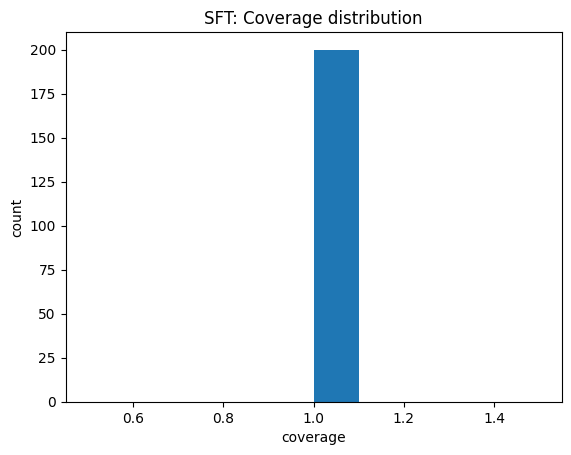

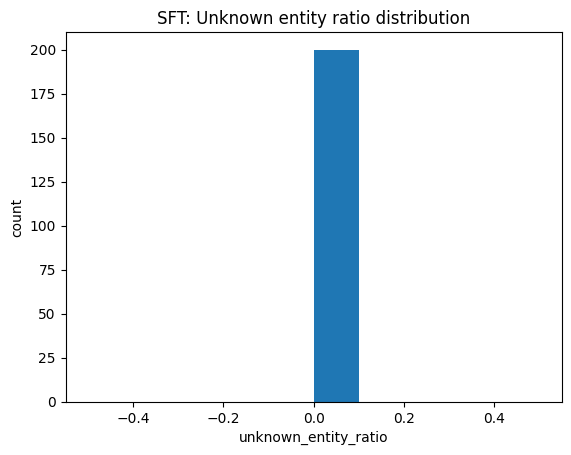

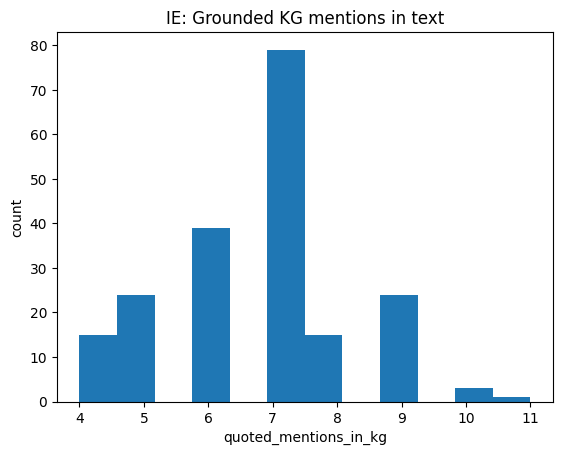

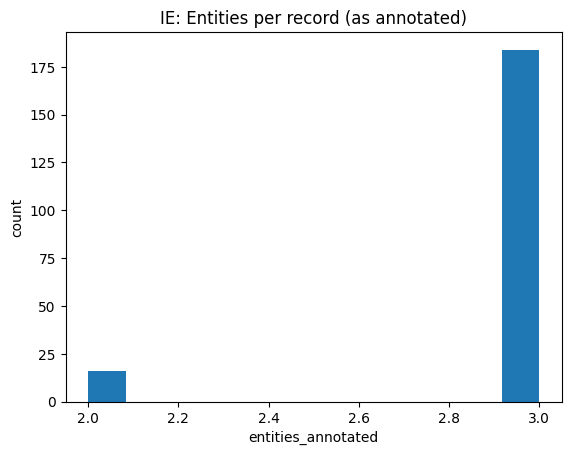

In [90]:
import json, re
import pandas as pd
import matplotlib.pyplot as plt

SFT_PATH = "mk_kgast_sft.jsonl"
IE_PATH  = "mk_kgast_ie.jsonl"

def read_jsonl(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return rows

def extract_quoted(text: str):
    return [s.strip() for s in re.findall(r"„([^“]+)“", text or "")]

def collect_kg_entities(rec):
    ents = set()
    kg = rec.get("kg_input") or []
    for t in kg:
        if isinstance(t, (list, tuple)) and len(t) >= 3:
            ents.add(str(t[0])); ents.add(str(t[2]))
        elif isinstance(t, dict):
            h = t.get("head") or t.get("subject")
            o = t.get("tail") or t.get("object")
            if h is not None: ents.add(str(h))
            if o is not None: ents.add(str(o))
    return ents

sft = read_jsonl(SFT_PATH)
ie  = read_jsonl(IE_PATH)


sft_df = pd.DataFrame([{
    "text": (rec.get("completion") or rec.get("text") or "").strip(),
    "coverage": (rec.get("meta", {}) or {}).get("coverage"),
    "unknown_entity_ratio": (rec.get("meta", {}) or {}).get("unknown_entity_ratio"),
} for rec in sft])
sft_df["text_words"] = sft_df["text"].str.split().str.len().fillna(0).astype(int)

ie_rows = []
for rec in ie:
    text = (rec.get("text") or rec.get("completion") or "").strip()
    meta = rec.get("meta", {}) or {}
    ann  = rec.get("annotations", {}) or {}
    kg_ents = collect_kg_entities(rec)
    quoted = extract_quoted(text)
    grounded = [q for q in quoted if q in kg_ents]
    ie_rows.append({
        "text": text,
        "coverage": meta.get("coverage"),
        "unknown_entity_ratio": meta.get("unknown_entity_ratio"),
        "text_words": len(text.split()) if text else 0,
        "quoted_mentions_in_kg": len(grounded),
        "entities_annotated": len(ann.get("entities") or []),
        "relations_annotated": len(ann.get("relations") or []),
    })
ie_df = pd.DataFrame(ie_rows)

# --- Evaluation 1: summary ---
def summarize(name, df):
    cov = pd.to_numeric(df["coverage"], errors="coerce")
    unk = pd.to_numeric(df["unknown_entity_ratio"], errors="coerce")
    print(f"\n=== {name} summary ===")
    print("records:", len(df))
    print("avg words:", float(df["text_words"].mean()))
    if cov.notna().any():
        print("coverage mean/median:", float(cov.mean()), float(cov.median()))
    if unk.notna().any():
        print("unknown ratio mean/median:", float(unk.mean()), float(unk.median()))
    if "entities_annotated" in df.columns:
        print("avg entities:", float(df["entities_annotated"].mean()))
        print("avg relations:", float(df["relations_annotated"].mean()))
        print("avg grounded mentions:", float(df["quoted_mentions_in_kg"].mean()))

summarize("SFT", sft_df)
summarize("IE", ie_df)

# --- Evaluation 2: “grounding vs annotations” sanity ---
print("\nIE grounding sanity:")
print("records with >=4 grounded mentions:", int((ie_df["quoted_mentions_in_kg"] >= 4).sum()), "/", len(ie_df))
print("records with 0 annotated entities:", int((ie_df["entities_annotated"] == 0).sum()), "/", len(ie_df))

# --- Viz 1: coverage (SFT) ---
plt.figure()
plt.hist(pd.to_numeric(sft_df["coverage"], errors="coerce").dropna(), bins=10)
plt.title("SFT: Coverage distribution")
plt.xlabel("coverage")
plt.ylabel("count")
plt.show()

# --- Viz 2: unknown entity ratio (SFT) ---
plt.figure()
plt.hist(pd.to_numeric(sft_df["unknown_entity_ratio"], errors="coerce").dropna(), bins=10)
plt.title("SFT: Unknown entity ratio distribution")
plt.xlabel("unknown_entity_ratio")
plt.ylabel("count")
plt.show()

# --- Viz 3: IE grounding + entity density ---
plt.figure()
plt.hist(ie_df["quoted_mentions_in_kg"], bins=12)
plt.title("IE: Grounded KG mentions in text")
plt.xlabel("quoted_mentions_in_kg")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(ie_df["entities_annotated"], bins=12)
plt.title("IE: Entities per record (as annotated)")
plt.xlabel("entities_annotated")
plt.ylabel("count")
plt.show()
